## Intro

This notebook covers:<br/>
- Data preprocessing
- NLP data analysis

TODO:</br>
remove texts with one word</br>
replace numbers

## Prepare

Install packages

In [ ]:
!pip install git+https://git@github.com/kavgan/word_cloud.git &> /dev/null
!pip install -q spacy

Imports

In [ ]:
# deep learning
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

# load data
from google_drive_downloader import GoogleDriveDownloader as gdd
from pathlib import Path

# visualization
import matplotlib.pyplot as plt
from word_cloud.word_cloud_generator import WordCloud
from IPython.core.display import HTML

# data science
import pandas as pd
import spacy
import numpy as np

# other
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

Settings

In [ ]:
TRAIN_DATASET_PATH = '/tmp/train-en.tsv'
EVAL_DATASET_PATH = '/tmp/eval-en.tsv'
TRAIN_DATASET_GDRIVE_ID = '196d23FA_YFJTpu_yDRpXjBG6DPKs9WI2'
EVAL_DATASET_GDRIVE_ID = '1p4O7Y2ePV17gPbwPTOio5EM7QMXHFI5V'
RANDOM_STATE = 42
LABEL = 'label'
TEXT = 'text'

Check device

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Number of gpu devices:', torch.cuda.device_count())
if torch.cuda.device_count() > 0:
    print('Device name:', torch.cuda.get_device_name(0))
print('Device type:', device)
print('PyTorch version:', torch.__version__)

Number of gpu devices: 0
Device type: cpu
PyTorch version: 1.9.0+cu102


Get data

In [ ]:
def download_data_from_gdrive(local_path, gdrive_file_id):
    if not Path(local_path).is_file():
        gdd.download_file_from_google_drive(
            file_id=gdrive_file_id,
            dest_path=local_path,
        )

In [ ]:
download_data_from_gdrive(TRAIN_DATASET_PATH, TRAIN_DATASET_GDRIVE_ID)

## Analyze

Load data

In [ ]:
df = pd.read_csv(TRAIN_DATASET_PATH, delimiter='\t', names=[LABEL, TEXT])
df.sample(5)

,label,text
9529,alarm/time_left_on_alarm,"How long before my ""dinner"" alarm goes off?"
16962,weather/find,how many inches of rain
22438,reminder/show_reminders,Show my reminder
13946,weather/find,does London have any sun today
10302,weather/find,How hot is it going to be today


In [ ]:
df.describe()

,label,text
count,30521,30521
unique,12,24551
top,weather/find,cancel all alarms
freq,14047,42


6k duplicates :O

Remove duplicates

In [ ]:
df.drop_duplicates(subset=[TEXT], inplace=True)
df.describe()

,label,text
count,24551,24551
unique,12,24551
top,weather/find,Set my alarm to 8 am instead of 7
freq,11336,1


In [ ]:
df[LABEL].value_counts()

weather/find                11336
alarm/set_alarm              4180
reminder/set_reminder        4136
alarm/cancel_alarm           1422
reminder/cancel_reminder      850
alarm/show_alarms             774
reminder/show_reminders       657
alarm/modify_alarm            402
alarm/time_left_on_alarm      296
alarm/snooze_alarm            291
weather/checkSunset           119
weather/checkSunrise           88
Name: label, dtype: int64

In [ ]:
data = df[TEXT].tolist()
labels = df[LABEL].tolist()

Word cloud before preprocessing

In [ ]:
wc=WordCloud(use_tfidf=False)
embed_code=wc.get_embed_code(text=data,random_color=False,topn=50)
HTML(embed_code)

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [ ]:
def preprocess(text):
    text = text.lower()
    text = text.strip() 
    text = ' '.join(text.split())  # replace whitespace with single space

    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token for token in tokens if len(token) > 1]

    return ' '.join(tokens)

In [ ]:
data_clean = [preprocess(x) for x in tqdm(data)]

100%|██████████| 24551/24551 [01:08<00:00, 358.05it/s]


Possible new duplicates after preprocessing

In [ ]:
df[TEXT] = data_clean
print('Before removing duplicates:', len(df))
df.drop_duplicates(subset=[TEXT], inplace=True)
print('After removing duplicates:', len(df))

data_clean = df[TEXT].tolist()
labels = df[LABEL].tolist()

Before removing duplicates: 24551
After removing duplicates: 15542


~10k   :O

Word cloud after preprocessing

In [ ]:
wc=WordCloud(use_tfidf=False)
embed_code=wc.get_embed_code(text=data_clean,random_color=False,topn=30)
HTML(embed_code)

Show top words per class label

In [ ]:
def get_top_words(data_np, labels_np, class_label, top_n_words=15):
    data_by_category = data_np[np.where(labels_np==class_label)]
    df_by_category = pd.DataFrame(data_by_category, columns=[TEXT])
    top_words_series = df_by_category[TEXT].str.split(expand=True).stack().value_counts()[:top_n_words]
    top_words = top_words_series.index.tolist()
    frequencies = top_words_series.values.tolist()
    return top_words, frequencies

In [ ]:
data_np = np.array(data_clean)
labels_np = np.array(labels)

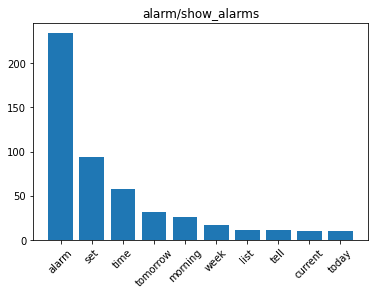

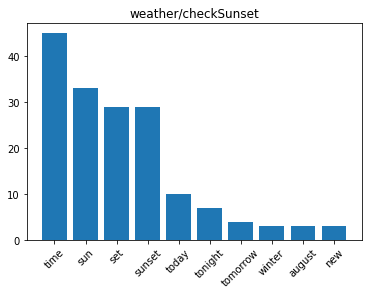

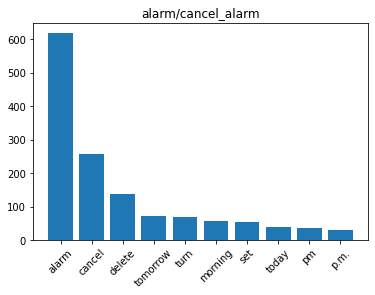

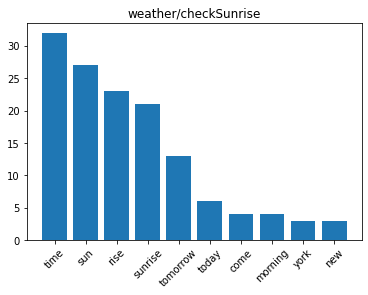

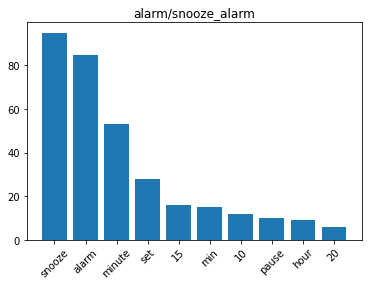

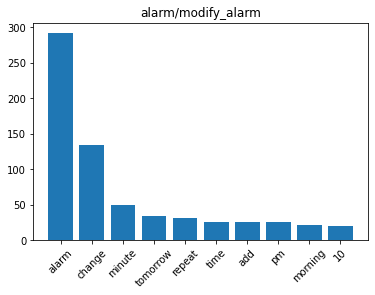

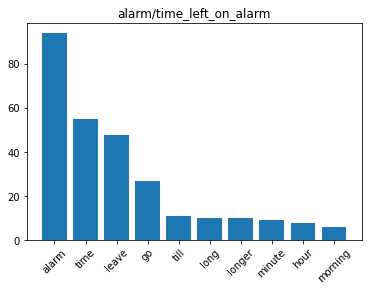

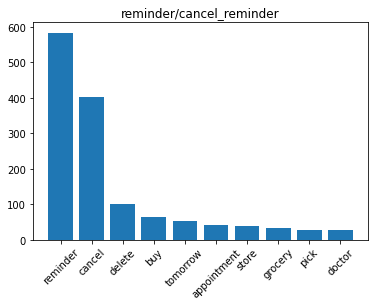

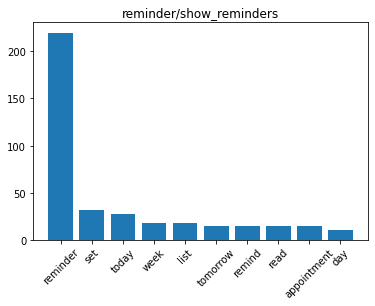

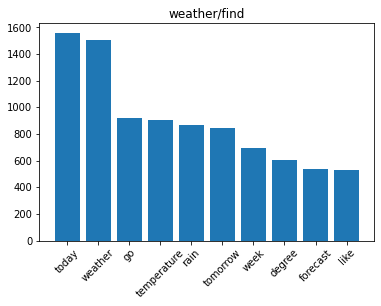

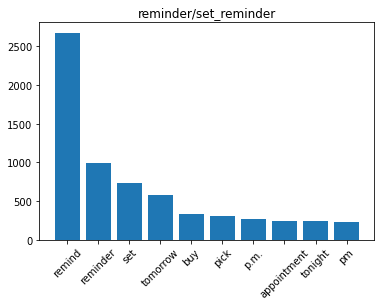

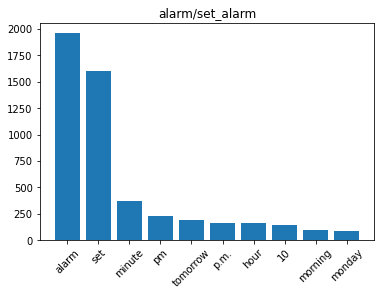

In [ ]:
for i, label in enumerate(list(set(labels))):
    top_words, frequencies = get_top_words(data_np, labels_np, label, top_n_words=10)
    plt.bar(top_words, frequencies)
    plt.xticks(rotation=45)
    plt.title(label)
    plt.show()

Text length

In [ ]:
df['length'] = df[TEXT].apply(lambda text: len(text))
df['word_count'] = df[TEXT].apply(lambda text: len(text.split()))

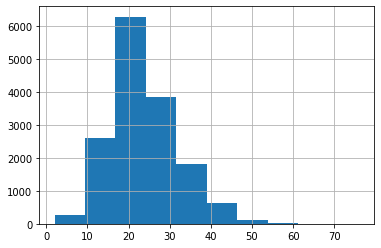

In [ ]:
df['length'].hist()

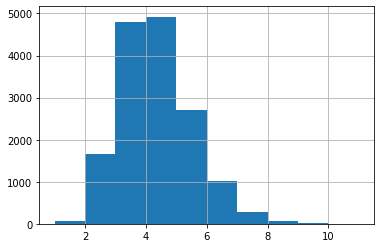

In [ ]:
df['word_count'].hist()